In [73]:
from inspect import signature
import time
import pprint
import pandas as pd
import requests
import sys
import json
import pymongo
from crossref.restful import Works
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
%matplotlib inline

In [2]:
# works = Works()

In [3]:
# help(works.query)

In [4]:
# for item in works.sample(1):
#     print(item.keys())

In [5]:
#query to be used
# "automated literature review"  OR  
# "automated literature search"  OR  
# "automated literature discovery"  AND  
# "NLP"  AND  
# "Machine Learning"

In [6]:
# works.query('Automatic Systematic Reviews using machine learning or natural language processing').count()

In [7]:
# query_string = 'Automated literature and systematic Reviews'

In [8]:
# w1 = works.query(bibliographic=query_string).select('DOI','title','is-referenced-by-count','score','subject')

In [9]:
# w1.count()

In [10]:
# li_all=[]
# start = time.time()
# for item in w1:
#     li_all.append(item.values())
# end = time.time()
# print(end-start)

In [11]:
#("automated literature review"  OR  "automated literature search"  OR  "automated literature discovery"  AND  "NLP"  AND  "Machine Learning")

In [12]:
# w1 = works.query(bibliographic='Systematic Literature Review', author='johannes', publisher_name='Wiley-Blackwell')

# for item in w1:
#     print(item['title'])

In [13]:
# download all the data related to query from crossref -- done
# then store it somewhere probably in mongodb
# remove duplicates
# 1 paper 1 row
# do clustering and find keywords for every cluster


In [14]:
# https://api.crossref.org/works?query.affiliation=Kalyani+University&filter=from-pub-date:2020-01-01,until-pub-date:2020-12-31,type:journal-article&select=DOI,title,container-title&rows=2&offset=0

In [15]:
# https://api.crossref.org/works?query.affiliation=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,container-title

In [16]:
# https://api.crossref.org/works?query.affiliation=Automated+literature+systematic+Reviews&filter=type:journal-article&select=DOI,publisher,title,is-referenced-by-count,score,subject,author,URL

In [17]:
# sys.getsizeof(response) #0.4 mb

In [18]:
# response = requests.get('https://api.crossref.org/works?query.title=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,score&rows=1000&cursor=*

In [19]:
#starts from here........

In [20]:
def get_latest_date():
    
    response = requests.get('https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,score,created&sort=created&order=desc&rows=1&cursor=*').text
    response_info = json.loads(response)
    latest_date = response_info['message']['items'][0]['created']['date-parts'][0]
    return latest_date
    

In [21]:
def get_oldest_date():
    
    response = requests.get('https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,score,created&sort=created&order=asc&rows=1&cursor=*').text
    response_info = json.loads(response)
    oldest_date = response_info['message']['items'][0]['created']['date-parts'][0]
    return oldest_date



In [22]:
latest_date = get_latest_date()
latest_date

[2022, 11, 27]

In [23]:
oldest_date = get_oldest_date()
oldest_date

[2002, 7, 25]

In [24]:
base_oldest = datetime.date(oldest_date[0],oldest_date[1],oldest_date[2])
base_latest = datetime.date(latest_date[0],latest_date[1],latest_date[2])
numweeks = 4
upd_date = base_oldest
date_list=[]
while upd_date <= base_latest:
    date_list.append(upd_date)
    upd_date = upd_date + datetime.timedelta(weeks=numweeks)
    
    date_list.append(upd_date)

In [25]:
def init_url(date_list):
    url = 'https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:'
    url = url+str(date_list[0])+',until-created-date:'+str(date_list[1])+'&select=DOI,title,score,created&rows=1000&cursor=*'
    return url

In [26]:
def cursor_url(date_list, cursor):
    url = 'https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:'
    url = url+str(date_list[0])+',until-created-date:'+str(date_list[1])+'&select=DOI,title,score,created&rows=1000&cursor='
    url = url + str(cursor)
    return url
    

In [27]:
db_name = "thesis"
test_client = pymongo.MongoClient('mongodb://localhost:27017/')
test_db = test_client[db_name]


def check_for_db(test_client,db_name):
    dblist = test_client.list_database_names()
    if db_name in dblist:
        print(db_name + ' ← database exists')
    else:
        print(db_name + ' ← database does NOT exists')
check_for_db(test_client,db_name) # check if database exists or not


# make collection
col_name='query_results'
test_col = test_db[col_name]

thesis ← database exists


In [28]:
date_list = list(set(date_list))

In [29]:
date_list.sort()

In [33]:
start = time.time()
cursors_li=[]
missed_records = []

for seg in range(len(date_list)):
    
    if len(date_list) == seg+1:
        break
    else:  
        url = init_url(date_list[seg:seg+2])
        response = requests.get(url).text
        response_info = json.loads(response)
        
        if len(response_info['message']['items']) !=0:
            pl = test_col.insert_many(response_info['message']['items'])
            a = response_info['message']['next-cursor']
            cursors_li.append(a)
            url = cursor_url(date_list[seg:seg+2], a)
            print(url,"\n\n*************")
            ct = 0
            while len(response_info['message']['items']) != 0:
                try:
                    response = requests.get(url).text
                    response_info = json.loads(response)
                    pl = test_col.insert_many(response_info['message']['items'])
                    #a = response_info['message']['next-cursor']
                    #url = cursor_url(date_list[seg:seg+2], a)
                except:
                    #if there is no response from the api for a url, which means either it timed out
                    #or exhausted, in that case the message will be
                    #empty and there will be nothing to enter in the database
                    #this exception handler will handle such cases
                    ct +=1
                    if ct==1:
                        print("All Extracted:moving on to next segment")
                    else:
                        #save the url
                        missed_records.append(url)
                        print("API timed out:skipping and moving on to next segment")
                        #get out of the while loop and fetch records for the next segment
                        break
        else:
            continue

        
end = time.time()
print(end-start)


https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2011-05-19,until-created-date:2011-06-16&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwSC2FjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFvMkDxZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAAADBILcWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3hFNFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEhxM0xZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABBuoHgWSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2011-06-16,until-created-date:2011-07-14&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwSFAFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAD3dXGRY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADBIUEWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3hGLFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEhxNPxZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABBuoM4

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2012-08-09,until-created-date:2012-09-06&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwTA-FjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAD3dgGBY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADBMD8WMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3hiwFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAD_FM8BZfNEZlTDBRZ1FuLWZ4NVhlZU9MYzN3AAAAABBuqngWSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2012-09-06,until-created-date:2012-10-04&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIj8oFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3dghBY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABbzM-0WR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASnBrUFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhxYwRZ

https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2013-10-03,until-created-date:2013-10-31&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASImR7FkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3eF_xY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABbzb50WR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASnEexFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhyEpxZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABB3wooWaDRJMjhrcXVUOGE3dDI1VDhnWHMyZw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2013-10-31,until-created-date:2013-11-28&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwW5uFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAD3eGaxY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADBbm8WMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3jVwFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAD_FvHBZfNEZlTDBRZ1FuLWZ4NVhlZU9MYzN3AAAAABBu0Uk

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2014-12-25,until-created-date:2015-01-22&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwX4fFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFvOAShZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAAADBfiAWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3jy8FjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEhyQEBZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABBu2t8WSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2015-01-22,until-created-date:2015-02-19&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIm8yFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3eQehY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABbzgUoWR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASnFRTFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhyQwRZ

https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2016-02-18,until-created-date:2016-03-17&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwY8nFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFvORmhZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAABbzkZkWR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAAR3kTTFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAD_GCPBZfNEZlTDBRZ1FuLWZ4NVhlZU9MYzN3AAAAABB31L0WaDRJMjhrcXVUOGE3dDI1VDhnWHMyZw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2016-03-17,until-created-date:2016-04-14&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwZCfFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFvOS1BZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAAADBkKAWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3kV3FjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEhydJhZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABBu5nY

https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2017-04-13,until-created-date:2017-05-11&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwaPMFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFvOl0hZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAAADBo80WMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3k46FjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEhyqdRZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABBu8gQWSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2017-05-11,until-created-date:2017-06-08&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIoW-FkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3emtxY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADBpKoWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAASnG-hFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhyrHRZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABBu8pQ

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2018-07-05,until-created-date:2018-08-02&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwbmYFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFvO8IBZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAAADBuZkWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3lhpFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAD_GbCBZfNEZlTDBRZ1FuLWZ4NVhlZU9MYzN3AAAAABBvAI4WSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2018-08-02,until-created-date:2018-08-30&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIpNDFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3e0ARY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABbzvT8WR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASnIFnFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhy8iBZ

https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2019-08-29,until-created-date:2019-09-26&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIp4tFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3e-4hY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABbzz2EWR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASnI8AFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhzJ7RZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABB39ZkWaDRJMjhrcXVUOGE3dDI1VDhnWHMyZw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2019-09-26,until-created-date:2019-10-24&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwc4nFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFvPQhxZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAAADBzigWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3mHiFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEhzKuxZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABBvDbU

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2020-11-19,until-created-date:2020-12-17&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIq17FkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3fN3BY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABbz6D4WR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASnKE1Fk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhzbUhZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABB4AyQWaDRJMjhrcXVUOGE3dDI1VDhnWHMyZw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2020-12-17,until-created-date:2021-01-14&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIq5GFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD3fOsxY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADB5t8WMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAASnKJGFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEhzcWxZ

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2022-01-13,until-created-date:2022-02-10&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASIr4FFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAFvQC1xZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAABb0AtgWR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASnLTRFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAD_HCvxZfNEZlTDBRZ1FuLWZ4NVhlZU9MYzN3AAAAABB4EZAWaDRJMjhrcXVUOGE3dDI1VDhnWHMyZw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2022-02-10,until-created-date:2022-03-10&select=DOI,title,score,created&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAAwgIuFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAD3ffsBY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADCAi8WMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR3noKFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEhzvsRZ

In [ ]:
# test_dict = { "surname": "Adamyan", "address": "Meliq Adamyan 1",
#              "city": "Yerevan" }
# pl = test_col.insert_one(test_dict)

In [24]:
db_name = "thesis"
test_client = pymongo.MongoClient('mongodb://localhost:27017/')
test_db = test_client[db_name]


def check_for_db(test_client,db_name):
    dblist = test_client.list_database_names()
    if db_name in dblist:
        print(db_name + ' ← database exists')
    else:
        print(db_name + ' ← database does NOT exists')
check_for_db(test_client,db_name) # check if database exists or not

thesis ← database exists


In [25]:
col_name='query_results'
test_col = test_db[col_name]

In [26]:
x = test_col.find()

In [27]:
li_all=[]
for data in x:
    li_all.append(data)

In [28]:
len(li_all)

2307235

In [29]:
li_all[1:3]

[{'_id': ObjectId('63813d65d070f257fb00b559'),
  'DOI': '10.1080/146392400445891',
  'title': ['Software reviews'],
  'score': 15.120222,
  'created': {'date-parts': [[2002, 7, 26]],
   'date-time': '2002-07-26T12:14:43Z',
   'timestamp': 1027685683000}},
 {'_id': ObjectId('63813d65d070f257fb00b55a'),
  'DOI': '10.1046/j.1365-3113.2002.00180.x',
  'title': ['Book Reviews'],
  'score': 15.046331,
  'created': {'date-parts': [[2002, 7, 28]],
   'date-time': '2002-07-28T21:46:32Z',
   'timestamp': 1027892792000}}]

In [30]:
df_all = pd.DataFrame(li_all)

In [31]:
#drop duplicates is present
df_all.drop_duplicates(subset=['DOI'],inplace=True)

In [32]:
df_all.shape

(2056652, 5)

In [33]:
df_all.head()

,_id,DOI,title,score,created
0,63813d65d070f257fb00b558,10.1136/bmj.323.7312.546,[Assessment of therapeutic safety in systemati...,17.089752,"{'date-parts': [[2002, 7, 27]], 'date-time': '..."
1,63813d65d070f257fb00b559,10.1080/146392400445891,[Software reviews],15.120222,"{'date-parts': [[2002, 7, 26]], 'date-time': '..."
2,63813d65d070f257fb00b55a,10.1046/j.1365-3113.2002.00180.x,[Book Reviews],15.046331,"{'date-parts': [[2002, 7, 28]], 'date-time': '..."
3,63813d65d070f257fb00b55b,10.1136/bmj.323.7306.224,[Systematic reviews in health care: Systematic...,14.980785,"{'date-parts': [[2002, 7, 27]], 'date-time': '..."
4,63813d65d070f257fb00b55c,10.1046/j.1365-3113.1999.00077.x,[Book Reviews],14.893698,"{'date-parts': [[2002, 7, 26]], 'date-time': '..."


In [34]:
df_all.isna().sum() #no na values

_id           0
DOI           0
title      2542
score         0
created       0
dtype: int64

In [35]:
df_all.dropna(subset=['title'],inplace=True)

In [36]:
df_all.shape

(2054110, 5)

In [37]:
text = " ".join(tl[0] for tl in df_all.title)

In [75]:
text[0:1000]

'Assessment of therapeutic safety in systematic reviews: literature review Software reviews Book Reviews Systematic reviews in health care: Systematic reviews of evaluations of prognostic variables Book Reviews Systematic reviews in health care: Systematic reviews of evaluations of diagnostic and screening tests Respiratory rehabilitation in chronic obstructive pulmonary\n      disease: summary of a systematic overview of the literature Book Reviews A new approach to automated pollen analysis Book Reviews Systematic reviews An automated iterative procedure for determining palaeodoses using the SARA method Book Reviews Book Reviews Book Reviews Book Reviews Systematic salt effects in the automated determination of nutrients in seawater Book Reviews Book Reviews Book Reviews Book Reviews Systematic reviews Case reports, case series and systematic reviews Systematic reviews of chemotherapy and endocrine therapy in metastatic breast cancer The quality of systematic reviews List of Book Rev

In [39]:
cleaned_text = re.sub('\W+',' ',text)

In [74]:
cleaned_text[0:1000]

'Assessment of therapeutic safety in systematic reviews literature review Software reviews Book Reviews Systematic reviews in health care Systematic reviews of evaluations of prognostic variables Book Reviews Systematic reviews in health care Systematic reviews of evaluations of diagnostic and screening tests Respiratory rehabilitation in chronic obstructive pulmonary disease summary of a systematic overview of the literature Book Reviews A new approach to automated pollen analysis Book Reviews Systematic reviews An automated iterative procedure for determining palaeodoses using the SARA method Book Reviews Book Reviews Book Reviews Book Reviews Systematic salt effects in the automated determination of nutrients in seawater Book Reviews Book Reviews Book Reviews Book Reviews Systematic reviews Case reports case series and systematic reviews Systematic reviews of chemotherapy and endocrine therapy in metastatic breast cancer The quality of systematic reviews List of Book Reviews Identif

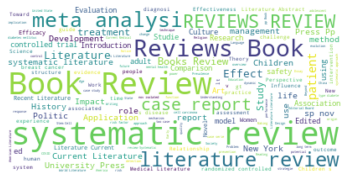

In [43]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["])

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 800,stopwords=stopwords, background_color="white").generate(cleaned_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:

#converted the title type from list to string
df_all['title'] =  df_all['title'].map(lambda x: x[0])

In [50]:
df_all.head()

,_id,DOI,title,score,created
0,63813d65d070f257fb00b558,10.1136/bmj.323.7312.546,Assessment of therapeutic safety in systematic...,17.089752,"{'date-parts': [[2002, 7, 27]], 'date-time': '..."
1,63813d65d070f257fb00b559,10.1080/146392400445891,Software reviews,15.120222,"{'date-parts': [[2002, 7, 26]], 'date-time': '..."
2,63813d65d070f257fb00b55a,10.1046/j.1365-3113.2002.00180.x,Book Reviews,15.046331,"{'date-parts': [[2002, 7, 28]], 'date-time': '..."
3,63813d65d070f257fb00b55b,10.1136/bmj.323.7306.224,Systematic reviews in health care: Systematic ...,14.980785,"{'date-parts': [[2002, 7, 27]], 'date-time': '..."
4,63813d65d070f257fb00b55c,10.1046/j.1365-3113.1999.00077.x,Book Reviews,14.893698,"{'date-parts': [[2002, 7, 26]], 'date-time': '..."


In [52]:
#lowercase
df_all['title'] = df_all['title'].map(lambda x: x.lower(  ))

In [77]:

df_all['title']= df_all['title'].map(lambda x: remove_stopwords(x))

#n-gram transformation, tokenizing
tokenize = df_all['title'].map(lambda x: x.split())

df_all.head()

,_id,DOI,title,score,created
0,63813d65d070f257fb00b558,10.1136/bmj.323.7312.546,assessment therapeutic safety systematic revie...,17.089752,"{'date-parts': [[2002, 7, 27]], 'date-time': '..."
1,63813d65d070f257fb00b559,10.1080/146392400445891,software reviews,15.120222,"{'date-parts': [[2002, 7, 26]], 'date-time': '..."
2,63813d65d070f257fb00b55a,10.1046/j.1365-3113.2002.00180.x,book reviews,15.046331,"{'date-parts': [[2002, 7, 28]], 'date-time': '..."
3,63813d65d070f257fb00b55b,10.1136/bmj.323.7306.224,systematic reviews health care: systematic rev...,14.980785,"{'date-parts': [[2002, 7, 27]], 'date-time': '..."
4,63813d65d070f257fb00b55c,10.1046/j.1365-3113.1999.00077.x,book reviews,14.893698,"{'date-parts': [[2002, 7, 26]], 'date-time': '..."


In [78]:
#train W2V model, generate W2V embeddings
# define training data
sentences = tokenize
# train model
model = Word2Vec(sentences, min_count=1)

In [79]:
# summarize the loaded model
print(model)

Word2Vec<vocab=986920, vector_size=100, alpha=0.025>


In [80]:
# summarize vocabulary
words = list(model.wv.key_to_index)
print(words[0:10])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

['review', 'reviews', 'literature', 'systematic', 'book', 'automated', 'case', 'meta-analysis', 'report', 'new']
Word2Vec<vocab=986920, vector_size=100, alpha=0.025>


In [82]:
#calculate similarity, reduce dimensions, plot graph
model.wv.most_similar('literature')

[('brief', 0.6584404110908508),
 ('literature.', 0.6444339752197266),
 ('comprehensive', 0.6369640231132507),
 ('systematic', 0.6202263236045837),
 ('literature”', 0.6049164533615112),
 ('experience', 0.6041561961174011),
 ('discussion', 0.5958854556083679),
 ('findings', 0.5947323441505432),
 ('literature?', 0.581947386264801),
 ('narrative', 0.5806236863136292)]

In [ ]:
# print(pl.inserted_id)


In [ ]:
# test_df = pd.DataFrame(li,columns=['objId','DOI','title','score'])

In [ ]:
#response_info['message']['items']

In [ ]:
## insert many players
# db_name='players'
# col_name='coach'
# test_client = pymongo.MongoClient("mongodb://localhost:27017/")
# test_db = test_client[db_name]
# test_col = test_db[col_name]
# test_list=[{ "surname": "player1", "address": "Meliq Adamyan 1",
#             "city": "Yerevan1" },
#            { "surname": "player2", "address": "Meliq Adamyan 2",
#             "city": "Yerevan2" },
#            { "surname": "player3", "address": "Meliq Adamyan 3",
#             "city": "Yerevan3" },
#            { "surname": "player4", "address": "Meliq Adamyan 4",
#             "city": "Yerevan4" }
#            ]

#print list of the _id values of the inserted players:
